In [86]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import folium
import pickle
import numpy as np
from ipywidgets import interact
import json

In [54]:
pickle_file="./Data/uni_df.pickle"
df=pickle.load(open(pickle_file,'rb'))

In [41]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.feature_selection import VarianceThreshold
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import RFE
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

def create_target_and_covariate_df(path_to_pkl):
    '''
    path_to_pkl: path to the pickle file.
    outputs two dataframes, one for the independant variables one for the dependant variables
    '''
    
    uni_df = pd.read_pickle(path_to_pkl)
    uni_df = uni_df.drop(columns=['Area', 'Year'])
    target_variables_df = uni_df[['(GDP, million $)', '(Consumer price indices, %)']]
    covariates_df = uni_df.drop(columns=['(GDP, million $)', '(Consumer price indices, %)'])
    
    return covariates_df, target_variables_df


def drop_feature_pearson_correlation(threshold, target_variable, target_variable_name, dataframe):
    
    '''
    threshold: the minimum amount of correlation required to keep the feature
    target_variable_name: string GDP or CPI
    normalised_dataset: the normalised dataset of feature
    target_variable: pandas series that contains the value of the target_varibale_name
    that we add to the normalised dataset
    
    '''
    copy_dataframe = dataframe.copy()
    copy_dataframe[target_variable_name] = target_variable
    cor = copy_dataframe.corr()
    cor_target = abs(cor[target_variable_name])
    
    relevant_features = cor_target[cor_target > threshold]
    
    return list(relevant_features.keys())

def drop_too_corelated_featues(threshold, dataframe):
    
    corr_matrix = dataframe.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    
    return dataframe.drop(dataframe[to_drop], axis=1)
    

def feature_augmentation(degree, covariates_df):
    poly = PolynomialFeatures(degree)
    output_nparray =  poly.fit_transform(covariates_df)

    
    output_df = pd.DataFrame(output_nparray, columns = poly.get_feature_names(covariates_df.columns))
    
    return output_df

def split_and_standardization_dataset(target_variables, covariates, test_size, random, type_return = 'numpy'  ):
    
    '''
    
    target_variables: pandas dataframe that contains the target variables
    covariates: pandas dataframe that contains the independant variables
    test_size: the proportion of the dataset to include in the test split
    type_return: 'numpy' if return numpy array, 'pandas' if return pandas dataframe
    '''
    target_variables_numpy = target_variables.to_numpy()
    covariates_numpy = covariates.to_numpy()
    X_train, X_test, Y_train, Y_test = train_test_split(covariates, target_variables_numpy, test_size=test_size, random_state = random)
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train_normalized = scaler.transform(X_train)
    X_test_normalized = scaler.transform(X_test)
    
    if type_return == 'numpy':
        
        return X_train_normalized, X_test_normalized, Y_train, Y_test
    
    elif type_return == 'pandas':
        
        X_test_normalized_df = pd.DataFrame(X_test_normalized, columns = list(covariates.columns))
        X_train_normalized_df = pd.DataFrame(X_train_normalized,columns= list(covariates.columns))
        Y_train_df = pd.DataFrame(Y_train, columns= list(target_variables.columns))
        Y_test_df = pd.DataFrame(Y_test, columns= list(target_variables.columns))
        
        return X_train_normalized_df, X_test_normalized_df, Y_train_df, Y_test_df

def fit_model_lasso(regularisation_parameters, covariates_df, target_df, nb_fold_CV):
    
    lasso = Lasso()
    
    parameters = {'alpha': regularisation_parameters}
    
    lasso_regressor = GridSearchCV(lasso, parameters, scoring = 'neg_mean_squared_error', cv = nb_fold_CV)
    lasso_regressor.fit(covariates_df, target_df)

    best_param = lasso_regressor.best_params_['alpha']
    print('The best regularization parameter is ', best_param)


    lasso = Lasso(alpha=best_param)
    lasso.fit(covariates_df, target_df)
    return lasso.coef_
    
    
    
def RFECV_lasso_2(covariate, target,  random, nb_fold = 5,):
    
    cols = list(covariate.columns)
    X_train_, X_test_, Y_train_, Y_test_ = split_and_standardization_dataset(target, covariate, 0.2, type_return='numpy', random = random)
    #print('shape of Y_train_', Y_train_.shape, 'type of Y_train_', type(Y_train_))
    model = Lasso()
    
    rfecv = RFECV(estimator = model, step = 1, cv = nb_fold, scoring = 'neg_mean_squared_error')
    rfecv.fit(X_train_, np.ravel(Y_train_))
    print("Optimal number of features : %d" % rfecv.n_features_)
    
    temp = pd.Series(rfecv.support_,index = cols)
    selected_features = temp[temp==True].index

    print(selected_features)
    

    # plt.figure()
    # plt.xlabel("Number of features selected")
    # plt.ylabel("Cross validation score")
    # plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
    # plt.show()
        
    return selected_features



    

def main():

    RANDOM_SEED = 29

    params = {

        'target' : '(GDP, million $)',
        'name of target': 'GDP',
        'pearson correlation threshold': 0.4,
        'inter correlation threshold': 0.9, 
        'nb_fold_CV': 5, 
        'degree augmentation': 1




    }

    covariates_df, target_variables_df = create_target_and_covariate_df('./Data/uni_df.pkl')
    summed_covariates_df = covariates_df.sum()
    keys = summed_covariates_df.keys()
    values = summed_covariates_df.values
    
    sorted_keys = [key for _,key in sorted(zip(values,keys))]

    covariates_df = covariates_df[sorted_keys[-30:]]
    
    # covariates_df = feature_augmentation(2, covariates_df)
    print('list of all features', list(covariates_df.columns.values))
    list_selected_features_GDP = drop_feature_pearson_correlation(params['pearson correlation threshold'], target_variables_df[params['target']], params['name of target'], covariates_df)
    print('amount of selected features', len(list_selected_features_GDP))
    print('selected features', list_selected_features_GDP)
    covariate_reduced_df = covariates_df[list_selected_features_GDP[:-1]]

    covariate_reduced_df = drop_too_corelated_featues(params['inter correlation threshold'], covariate_reduced_df)
    print('list of selected features after reduction', list(covariate_reduced_df.columns.values))
    # covariate_reduced_df = feature_augmentation(params['degree augmentation'], covariate_reduced_df)

    # selected_features = RFECV_lasso_2(covariate_reduced_df, target_variables_df[[params['target']]], random = RANDOM_SEED)
    # selected_covariate = covariate_reduced_df[selected_features]

    regularisation_parameters = np.linspace(start = 0.01, stop= 1, num = 20)

    # covariate_reduced_df = covariate_reduced_df[list(selected_covariate.columns.values)]

    target_df = target_variables_df[params['target']]

    nb_fold_CV = params['nb_fold_CV']

    param_lasso = fit_model_lasso(regularisation_parameters, covariate_reduced_df, target_df, nb_fold_CV = nb_fold_CV )

    keys = list(covariate_reduced_df.columns.values)
    #keys = selected_features
    values = param_lasso
   
    return dict(zip(keys, values))








In [83]:
weights=main()

list of all features ['Apples Crops Production tonnes', 'Grapes Crops Production tonnes', 'Horses Livestock production Head', 'Wheat Food export quantities tonnes', 'Cabbages and other brassicas Crops Production tonnes', 'Rye Crops Production tonnes', 'Sweet potatoes Crops Production tonnes', 'Maize Food import quantities tonnes', 'Soybeans Crops Production tonnes', 'Tomatoes Crops Production tonnes', 'Oats Crops Production tonnes', 'Buffaloes Livestock production Head', 'Cassava Crops Production tonnes', 'Wheat Food import quantities tonnes', 'Barley Crops Production tonnes', 'Chickens Live animals import quantities Head', 'Chickens Live animals export quantities Head', 'Rabbits and hares Livestock production Head', 'Maize Crops Production tonnes', 'Goats Livestock production Head', 'Turkeys Livestock production Head', 'Ducks Livestock production Head', 'Sugar beet Crops Production tonnes', 'Potatoes Crops Production tonnes', 'Wheat Crops Production tonnes', 'Pigs Livestock production

//anaconda3/envs/ada/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29421704109296.25, tolerance: 578161567166.3121
  positive)
//anaconda3/envs/ada/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2028824926107.75, tolerance: 616213877638.2041
  positive)


The best regularization parameter is  1.0


In [55]:
prod_cols=[col for col in df.columns if 'production' in col.lower() and 'live' in col.lower()]
heads=[col for col in prod_cols if '1000 head' in col.lower()]
noheads=[col for col in prod_cols if '1000 head' not in col.lower()]
print(len(heads),len(noheads))

8 15


In [56]:
print([s for s in heads if s in noheads])

[]


In [57]:
def convert_1000H_to_heads(df):
    cols_to_convert=[col for col in df.columns if '1000 head' in col.lower()]
    df[cols_to_convert]=df[cols_to_convert]*1000
    new_cols=[drop_words(s,2)+'Heads' for s in cols_to_convert]
    name_dic={old:new for old,new in zip(cols_to_convert,new_cols)}
    df.rename(columns=name_dic)
    return df

In [58]:
test=df[[heads[0],noheads[0]]]

In [59]:
convert_1000H_to_heads(test)


,Chickens Livestock production 1000 Head,Olives Crops Production tonnes
0,6000000.0,1200.0
1,6000000.0,1000.0
2,6000000.0,1200.0
3,6100000.0,1000.0
4,6100000.0,1300.0
...,...,...
9191,34000000.0,0.0
9192,35000000.0,0.0
9193,36000000.0,0.0
9194,36000000.0,0.0


In [70]:
def drop_words( s , w=1 , end=True):
    if end:
        return s.rsplit(' ',w)[0]
    else:
        return s.split(' ',w)[-1]

In [61]:
heads=[drop_words(s,2) for s in heads]
noheads=[drop_words(s,1) for s in noheads]

In [62]:
common=[s for s in heads if s not in noheads]

In [139]:
def compute_score(df,weights=None):
    
    def drop_words( s , w=1 , end=True):
        if end:
            return s.rsplit(' ',w)[0]
        else:
            return s.split(' ',w)[-1]
        
    df=df.set_index(['Area','Year'])
    
    import_cols=[col for col in df.columns if 'import' in col.lower()]
    export_cols=[col for col in df.columns if 'export' in col.lower()]
    prod_cols=[col for col in df.columns if 'production' in col.lower()]
    
    scores=pd.DataFrame(index=uni_df.index)
    
    columns={}
    
    for i,col in enumerate(import_cols):
        key=col+prod_cols[i]+export_cols[i]
        scores[key]=(uni_df[prod_cols[i]]*100/(
                                    uni_df[prod_cols[i]]+uni_df[import_cols[i]]-uni_df[export_cols[i]]))
        
        columns[key]=drop_words(col,3)
    if weights==None:
        scores=scores.rename(columns=columns)
        return scores
    
    features=[w for w in weights.keys()]
    temp=pd.DataFrame(index=df.index)
    scores=scores.fillna(0)
    for feat in features:
        temp=temp.merge(scores.filter(regex=feat),left_index=True,right_index=True)
    temp.columns=features
    temp['Agg']=0
    for feat in features:
        temp['Agg']=temp['Agg']+weights[feat]*temp[feat]
    scores=temp['Agg']
    return scores

In [140]:
df=pickle.load(open(pickle_file,'rb'))
compute_score(df, weights).describe()

count    273221.000000
mean          0.153065
std           5.869650
min       -2373.852599
25%           0.000000
50%           0.000000
75%           0.000000
max        1795.577543
Name: Agg, dtype: float64

In [142]:
weights

{'Apples Crops Production tonnes': 0.00038835122755090606,
 'Grapes Crops Production tonnes': 0.043072069534541305,
 'Wheat Food export quantities tonnes': 0.011350728929876288,
 'Soybeans Crops Production tonnes': -0.001271124985250068,
 'Maize Crops Production tonnes': 0.028315846463208876,
 'Turkeys Livestock production Head': 0.0056892714752312225}

In [141]:
compute_score(df)

Animals live nes Live animals  \
Area        Year                                  
Afghanistan 1970                            NaN   
            1971                            NaN   
            1972                            NaN   
            1973                            NaN   
            1974                            NaN   
...                                         ...   
Zimbabwe    2011                            NaN   
            2012                            NaN   
            2013                            NaN   
            2014                            NaN   
            2015                            NaN   

                  Anise, badian, fennel, coriander Food  Apples Food  \
Area        Year                                                       
Afghanistan 1970                                    NaN   109.274307   
            1971                                    NaN   104.161620   
            1972                                    NaN   127.102446   
            1973                                    NaN   117.137764   
            1974                                    NaN   124.753186   
...                                                 ...          ...   
Zimbabwe    2011                              64.242424    32.214541   
            2012                              57.971014    33.522434   
            2013                              66.666667    35.761444   
            2014                             100.000000   100.000000   
            2015                                    NaN          NaN   

                  Apricots Food  Artichokes Food  Asparagus Food  \
Area        Year                                                   
Afghanistan 1970     100.000000              NaN             NaN   
            1971     100.000000              NaN             NaN   
            1972     101.647956              NaN             NaN   
            1973     102.834957              NaN             NaN   
            1974     104.562234              NaN             NaN   
...                         ...              ...             ...   
Zimbabwe    2011      89.583333       100.000000       99.245283   
            2012      75.409836       100.000000       99.009901   
            2013      80.701754        99.667774       98.039216   
            2014     100.000000       100.000000      100.000000   
            2015            NaN              NaN             NaN   

                  Asses Live animals  Avocados Food  Bambara beans Food  \
Area        Year                                                          
Afghanistan 1970               100.0            NaN                 NaN   
            1971               100.0            NaN                 NaN   
            1972               100.0            NaN                 NaN   
            1973               100.0            NaN                 NaN   
            1974               100.0            NaN                 NaN   
...                              ...            ...                 ...   
Zimbabwe    2011               100.0     108.340284                 NaN   
            2012               100.0     173.564753                 NaN   
            2013               100.0     206.349206                 NaN   
            2014               100.0     100.000000                 NaN   
            2015                 NaN            NaN                 NaN   

                  Bananas Food  ...  Strawberries Food  Sugar beet Food  \
Area        Year                ...                                       
Afghanistan 1970           NaN  ...                NaN            100.0   
            1971           NaN  ...                NaN            100.0   
            1972           NaN  ...                NaN            100.0   
            1973           NaN  ...                NaN            100.0   
            1974      0.000000  ...                NaN            100.0   
...                        ... 

In [44]:
df=pickle.load(open(pickle_file,'rb'))
scores=compute_score(df)

In [47]:
features=list(weights.keys())

In [52]:
scores.shape

(9755, 103)

In [65]:
uni_df=pickle.load(open(pickle_file,'rb'))
uni_df=uni_df.set_index(['Area','Year'])

In [55]:
import_cols=[col for col in uni_df.columns if 'import' in col.lower()]
export_cols=[col for col in uni_df.columns if 'export' in col.lower()]
prod_cols=[col for col in uni_df.columns if 'production' in col.lower()]

Empty DataFrame
Columns: []
Index: [(Afghanistan, 1970), (Afghanistan, 1971), (Afghanistan, 1972), (Afghanistan, 1973), (Afghanistan, 1974), (Afghanistan, 1975), (Afghanistan, 1976), (Afghanistan, 1977), (Afghanistan, 1978), (Afghanistan, 1979), (Afghanistan, 1980), (Afghanistan, 1981), (Afghanistan, 1982), (Afghanistan, 1983), (Afghanistan, 1984), (Afghanistan, 1985), (Afghanistan, 1986), (Afghanistan, 1987), (Afghanistan, 1988), (Afghanistan, 1989), (Afghanistan, 1990), (Afghanistan, 1991), (Afghanistan, 1992), (Afghanistan, 1993), (Afghanistan, 1994), (Afghanistan, 1995), (Afghanistan, 1996), (Afghanistan, 1997), (Afghanistan, 1998), (Afghanistan, 1999), (Afghanistan, 2000), (Afghanistan, 2001), (Afghanistan, 2002), (Afghanistan, 2003), (Afghanistan, 2004), (Afghanistan, 2005), (Afghanistan, 2006), (Afghanistan, 2007), (Afghanistan, 2008), (Afghanistan, 2009), (Afghanistan, 2010), (Afghanistan, 2011), (Afghanistan, 2012), (Afghanistan, 2013), (Afghanistan, 2014), (Afghanistan, 2015), (Albania, 1970), (Albania, 1971), (Albania, 1972), (Albania, 1973), (Albania, 1974), (Albania, 1975), (Albania, 1976), (Albania, 1977), (Albania, 1978), (Albania, 1979), (Albania, 1980), (Albania, 1981), (Albania, 1982), (Albania, 1983), (Albania, 1984), (Albania, 1985), (Albania, 1986), (Albania, 1987), (Albania, 1988), (Albania, 1989), (Albania, 1990), (Albania, 1991), (Albania, 1992), (Albania, 1993), (Albania, 1994), (Albania, 1995), (Albania, 1996), (Albania, 1997), (Albania, 1998), (Albania, 1999), (Albania, 2000), (Albania, 2001), (Albania, 2002), (Albania, 2003), (Albania, 2004), (Albania, 2005), (Albania, 2006), (Albania, 2007), (Albania, 2008), (Albania, 2009), (Albania, 2010), (Albania, 2011), (Albania, 2012), (Albania, 2013), (Albania, 2014), (Albania, 2015), (Algeria, 1970), (Algeria, 1971), (Algeria, 1972), (Algeria, 1973), (Algeria, 1974), (Algeria, 1975), (Algeria, 1976), (Algeria, 1977), ...]

[9755 rows x 0 columns]

In [71]:
scores=pd.DataFrame(index=uni_df.index)
for i,col in enumerate(import_cols):
    if 
    scores[drop_words(col,3)]=(uni_df[prod_cols[i]]/(
                                uni_df[prod_cols[i]]+uni_df[import_cols[i]]-uni_df[export_cols[i]]))

In [76]:
weights

{'Apples Crops Production tonnes': 0.00038835122755090606,
 'Grapes Crops Production tonnes': 0.043072069534541305,
 'Wheat Food export quantities tonnes': 0.011350728929876288,
 'Soybeans Crops Production tonnes': -0.001271124985250068,
 'Maize Crops Production tonnes': 0.028315846463208876,
 'Turkeys Livestock production Head': 0.0056892714752312225}

In [64]:
import pandas as pd
import numpy as np
import seaborn as sns
import folium
from folium.plugins import TimestampedGeoJson
import json

In [65]:
def visualise_world_data(df,to_visualise,year,log=True):
    
    # importing geojson and transforming to pandas
    geo_data=json.load(open("Data/world-countries.json"))
    dics=geo_data['features']
    clean_dics=[]
    for country in dics:
        clean_dics.append({'Country':country['properties']['name'],
                          'geometry':country['geometry']})
    geo_df=pd.DataFrame(clean_dics)
    
    # cropping to df to data of interest
    df_visu=df[['Area','Year',to_visualise]]
    df_visu=df_visu[df_visu.Year==year]
    
    # cleaning country names
    df_visu.Area=df_visu.Area.apply(lambda x:correct_country_names(x,name_correction))
    df_visu=df_visu.explode('Area')
    
    # Merging with geo data
    df_visu=geo_df.merge(df_visu,how='left',left_on='Country',right_on='Area')
    
    if log:
        df_visu[to_visualise]=df_visu[to_visualise].apply(lambda x : np.log10(x))
    
    # creating Json string for folium
    features=[]
    for _,row in df_visu.iterrows():
        feature={
            'type' : 'Feature',
            
            'properties':{'name':row['Country'],
                         'value':row[to_visualise]},
            
            'geometry':row['geometry'],
            }
        features.append(feature)
    
    c=folium.Choropleth({'type':'FeatureCollection','features':features},
                  df_visu[['Country','(GDP, million $)']],
                  columns=['Country','(GDP, million $)'],
                  key_on='feature.properties.name',
                  fill_color='YlGn',
                  fill_opacity=0.7,
                  line_opacity=0.2,
                  nan_fill_opacity=0.0)
    c.geojson.add_child(folium.features.GeoJsonTooltip(['name','value']))
    m=folium.Map()
    c.add_to(m)
    return m

In [66]:
visualise_world_data(df,'(GDP, million $)',2002,True)

NameError: name 'correct_country_names' is not defined

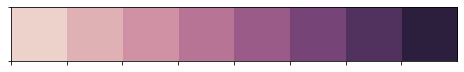

In [84]:
sns.palplot(sns.cubehelix_palette(8))

In [87]:
colors.to_hex(sns.cubehelix_palette(8)[1])

'#e1b1b4'

In [85]:
sns.cubehelix_palette(8)

[[0.9312692223325372, 0.8201921796082118, 0.7971480974663592],
 [0.8822898168737189, 0.695820866705742, 0.7065457119485431],
 [0.8135380254700676, 0.5705055182357822, 0.639280859468155],
 [0.7195800708349119, 0.45537982893127477, 0.5861062995810926],
 [0.6046906802634469, 0.35739308184976665, 0.5337407853692406],
 [0.46496993672552045, 0.26868986121314253, 0.4636527763640647],
 [0.3210194743259347, 0.19303051265196464, 0.3707881677724792],
 [0.1750865648952205, 0.11840023306916837, 0.24215989137836502]]

In [118]:
def visualise_world_data_no_c(df,to_visualise,year,log=True):
    
    color_scale = sns.cubehelix_palette(9)
    
    # importing geojson and transforming to pandas
    geo_data=json.load(open("Data/world-countries.json"))
    dics=geo_data['features']
    clean_dics=[]
    for country in dics:
        clean_dics.append({'Country':country['properties']['name'],
                          'geometry':country['geometry']})
    geo_df=pd.DataFrame(clean_dics)
    
    # cleaning df to allow merge with geo data
    name_correction = {'Czechia': "Czech Republic",
       'Russian Federation':'Russia',
       "Serbia":"Republic of Serbia",
       'The former Yugoslav Republic of Macedonia':'Macedonia',
       'China, mainland':'China',
       'Viet Nam':'Vietnam',
       'Venezuela (Bolivarian Republic of)':'Venezuela',
       'Iran (Islamic Republic of)':'Iran',
       'Syrian Arab Republic':"Syria",
       'Bolivia (Plurinational State of)': 'Bolivia',
       "Côte d'Ivoire": "Ivory Coast",
       'Congo':"Republic of the Congo",
       "Lao People's Democratic Republic":'Laos',
       "Democratic People's Republic of Korea":"North Korea",
       'Republic of Korea':"South Korea",
       'USSR':                            ['Armenia', 'Azerbaijan','Belarus', 'Estonia', 'Georgia',
                                               'Kazakhstan', 'Kyrgyzstan', 'Latvia', 'Lithuania',
                                               'Montenegro', 'Republic of Moldova', 'Russia',
                                               'Republic of Serbia', 'Timor-Leste', 'Turkmenistan', 'Ukraine',
                                               'Uzbekistan'],
       'Ethiopia PDR':                     ['Eritrea','Ethiopia'],
       'Yugoslav SFR':                     ['Kosovo', 'Slovenia', 'Croatia',
                                                'Macedonia', 'Bosnia and Herzegovina'],
       'Yemen Dem' :                       ['Yemen'],        
       'Czechoslovakia':                   ["Czech Republic", 'Slovakia'],
       'Netherlands Antilles (former)':    ['Curaçao', 'Sint Maarten (Dutch Part)'],
       'Sudan (former)':                   ['South Sudan', 'Sudan']}
    
    # usefull method to clean country names
    def correct_country_names(old_name, dic):
        if old_name in dic.keys() :
            return dic[old_name]
        return old_name
    
    # cropping to df to data of interest
    df_visu=df[df.Year==year][['Area',to_visualise]]
    # cleaning country names
    df_visu.Area=df_visu.Area.apply(lambda x:correct_country_names(x,name_correction))
    df_visu=df_visu.explode('Area')
    
    # Merging with geo data
    df_visu=geo_df.merge(df_visu,how='left',left_on='Country',right_on='Area')
    df_visu=df_visu.dropna()
    
    if log:
        df_visu[to_visualise]=df_visu[to_visualise].apply(lambda x : np.log10(x))
    
    # creating bins for color scaling
    ma_value=df_visu[to_visualise].max()
    mi_value=df_visu[to_visualise].min()
    bins=np.linspace(mi_value,ma_value,8)
    
    # creating Json string for folium
    features=[]
    for _,row in df_visu.iterrows():
        color=np.digitize(row[to_visualise],bins)
        feature={
            'type' : 'Feature',
            
            'properties':{'name':row['Country'],
                          'value': '{:.2E}'.format(np.power(10,row[to_visualise])),
                          'color':colors.to_hex(color_scale[color])},
            'geometry':row['geometry']
            }
        features.append(feature)
    
    def style(feature):
        
        if feature['properties']['value']==np.nan:
            print("lol")
            opac=0
        else:
            opac=0.8
        return {'fillOpacity':opac,
                   'weight':0.1,
                   'fillColor':feature['properties']['color']}
    geo_data=folium.GeoJson({'type':'FeatureCollection','features':features},style_function=style,tooltip=folium.features.GeoJsonTooltip(['name','value']))
    m=folium.Map()
    geo_data.add_to(m)
    return m

In [119]:
visualise_world_data_no_c(df,'(GDP, million $)',2002,True)

In [115]:
val=1147.4789711222
print('{:.2E}'.format(val))

1.15E+03


In [13]:
test=folium.Map()
folium.GeoJson(geo).add_to(test)
test